Created: 2020.08.13

Modified: 2020.08.28

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import parallel

import random
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('functions')

%aimport functions00, functions01
from functions00 import *
from functions01 import *

import functions32 as f32
import functions50 as f50

In [4]:
mk_get_host_info()

**********************************************************************************************************************************
Settings:
	HOST:  mmiv-ml-titan
	PATH_ROOT_DATA:  /data-10tb/shared/skull/train-3d-iso
	PATH_GIT_HUB:  /data-10tb/marek/github_codes/skull-stripping-1/fastai
	PATH_2D: /data-10tb/shared/skull

3D NIFTI image DF paths (_mk_3D):
	IXI_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/ixi_test_mk_3d.csv
	TEST_3D : /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/test_mk_3d.csv
	TRAIN_VAL_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/train_val_mk_3d.csv
	NFBS_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/nfbs_test_mk_3d.csv

Error files (pickle):
	ERROR_FILES: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/error_files
***********************************************************

# 2D AXIAL - T1 biascorr - TEST_3D

#### Some global variables

In [5]:
TEST_SET_NAME = 'IXI_TEST_3D'
SAVE_PTH_301_DATA = PATH_2D / 'pred' / '3.01' / TEST_SET_NAME
SAVE_PTH_301_FIGS = PATH_2D / 'pred' / '3.01' / TEST_SET_NAME / 'figs'
SAVE_PTH_301_CSV = PATH_GIT_HUB / '5.0'

In [6]:
mk_wrap_text(TEST_SET_NAME)

*********************
*** IXI_TEST_3D   ***
*********************


___

### Load predictions from a matrix

In [46]:
%%time
load = 0
if load:
    save_name = f'3.01_{TEST_SET_NAME}_uncompressed_results.npz'
    save_pth = SAVE_PTH_301_DATA / save_name
    X = np.load(save_pth, allow_pickle=True)
    
    full_names = X['full_names']
    fsl_128 = X['fsl_128']
    pred_128 = X['pred_128']
    x_128 = X['x_128']
    mask_full_path = X['mask_full_path']

CPU times: user 6.93 s, sys: 1.66 s, total: 8.58 s
Wall time: 8.59 s


___

### Prepare **df_2d with** basic info and Dice and Jaccards coefs

Based on index obtained from df (5.01_model_3.01_1_TEST_predictions.ipynb) we can manipulate data saved to a npz file: 
- fsl_128 - 128x128  fsl_output slices,
- pred_128 - 128x128 predicted slces,
- x_128 - 128x128 interpolated by fastai image,
- full_names - 2d image full path,
- mask_full_path - 2d mask full path.


### Load 2d df

In [7]:
save_name = f'3.01_{TEST_SET_NAME}_info_2d.csv'
save_pth = SAVE_PTH_301_CSV / save_name
df_2d = pd.read_csv(save_pth)    
print(df_2d.shape)
df_2d.head(2)

(94520, 4)


,full,mask_full_path,patient,db
0,/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_000.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_brain_mask_iso_nn...,/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_,IXI
1,/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_001.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_brain_mask_iso_nn...,/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_,IXI


### Load 3d df

In [8]:
create_df_3d = 0

save_name = f'3.01_{TEST_SET_NAME}_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name
df_3d = pd.read_csv(save_pth)
print(df_3d.shape)
df_3d.head(2)

(556, 7)


,full,mask_full_path,patient,db,dice,jaccard,hausdorff
0,/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_000.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_brain_mask_iso_nn...,/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_,IXI,0.983481,0.967499,5.000000
1,/data-10tb/shared/skull/axial-2d//test/IXI/IXI012-HH-1211-T1.anat/T1_biascorr_iso_000.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI012-HH-1211-T1.anat/T1_biascorr_brain_mask_iso_nn_0...,/data-10tb/shared/skull/axial-2d//test/IXI/IXI012-HH-1211-T1.anat/T1_biascorr_iso_,IXI,0.981799,0.964248,22.912878


___

#### TESTS

In [49]:
tests = 0
if tests:
    # Get names from df; identify db's in a test set
    print(f50.get_db_names(df_2d))
    
    # Get one db from the entire test set
    dfn, idx = f50.get_single_db(df_2d,'IXI')
    
    # get patients name from a full df or a choosen DB
    pat = f50.get_all_patient_list_from_df(dfn)
    print(len(pat))
    
    pt = pat[0]
    dfp, idxp = f50.get_one_patient(dfn, pt)
    print(idxp)
    
    
    # Get images of a patient
    # one patient (P) indices, acquired above

    xP = x_128[idxp]
    yP = fsl_128[idxp]
    pP = pred_128[idxp]
    
    print(xP.size, xP.shape)

['IXI']
556
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            160, 161, 162, 163, 164, 165, 166, 167, 168, 169],
           dtype='int64', length=170)
2785280 (170, 128, 128)


___

### Visualization

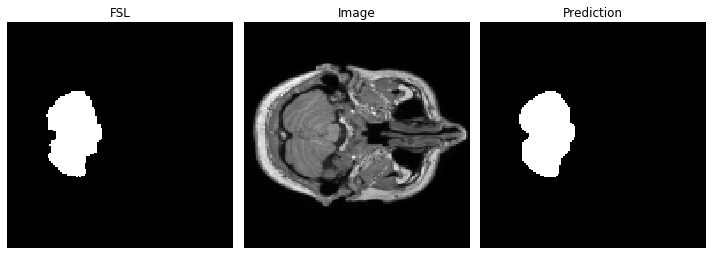

In [20]:
k = 7500
f50.vis_2d_from_slice(fsl_128[k], x_128[k], pred_128[k])

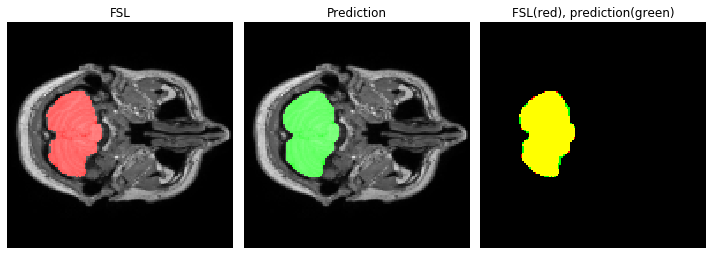

In [21]:
k = 7500
f50.vis_2d_from_slice_rgb(fsl_128[k], x_128[k], pred_128[k])

___

In [50]:
# one patient (P) indices, acquired above
xP = x_128[idxp]
yP = fsl_128[idxp]
pP = pred_128[idxp]
print(xP.shape, yP.shape, pP.shape)

(170, 128, 128) (170, 128, 128) (170, 128, 128)


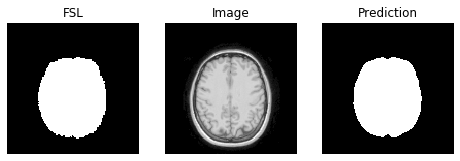

In [51]:
f50.vis_3d(yP,xP,pP, k=98)

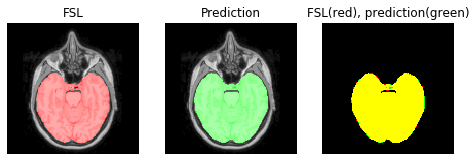

In [52]:
f50.vis_3d_rgb(yP,xP,pP, k=50)

___

### Identification of the smallest coefficient

In [53]:
dfs, idxs = f50.get_biggest_smallest_dice_jaccard_coefs(df_3d, db='IXI', sort_column='dice', max_min = 'min', N=3)
print(idxs)
dfs[['patient', 'dice', 'jaccard']]

*** Search for IXI ***
	Sort column: DICE
	Select: 3 MIN items

Int64Index([399, 379, 383], dtype='int64')


,patient,dice,jaccard
399,/data-10tb/shared/skull/axial-2d//test/IXI/IXI464-IOP-1029-T1.anat/T1_biascorr_iso_,0.883826,0.791835
379,/data-10tb/shared/skull/axial-2d//test/IXI/IXI443-HH-2215-T1.anat/T1_biascorr_iso_,0.914485,0.842443
383,/data-10tb/shared/skull/axial-2d//test/IXI/IXI447-Guys-0979-T1.anat/T1_biascorr_iso_,0.916918,0.846582


#### Get the single (the first) element with the worst dice

Saved file: /data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_IXI464-IOP-1029-T1.anat_T1_biascorr_iso_slice-50_rgb.png


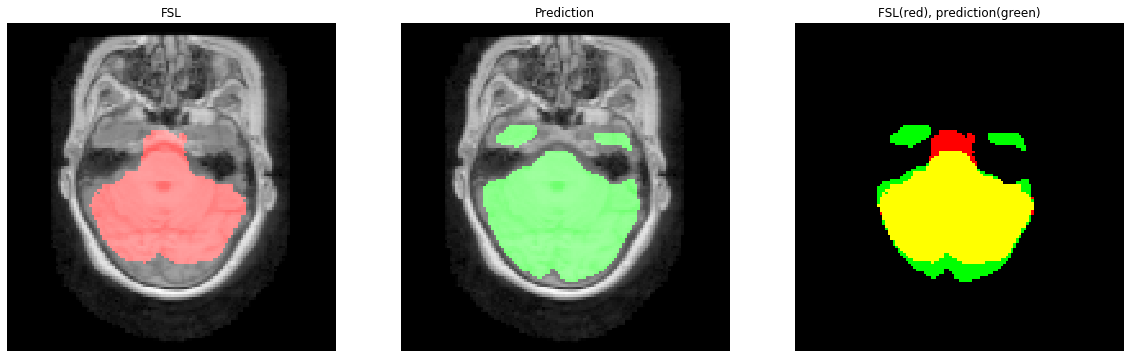

In [70]:
pat = dfs.patient.values.item(0)
#print(pat)
dfp, idxp = f50.get_one_patient(df_2d, pat)

# one patient (P) indices, acquired above
xP = x_128[idxp]
yP = fsl_128[idxp]
pP = pred_128[idxp]
#print(xP.shape, yP.shape, pP.shape)

# pat = '/data-10tb/shared/skull/axial-2d//test/IXI/IXI464-IOP-1029-T1.anat/T1_biascorr_iso_'
# name = IXI464-IOP-1029-T1.anat_T1_biascorr_iso
save_name_root = '_'.join(pat.split('/')[-2:])[:-1]
#print(save_name_root)

k = 50
save_name_rgb = Path(f'3.01_{TEST_SET_NAME}_{save_name_root}_slice-{k}_rgb.png')
save_pth_rgb = SAVE_PTH_301_FIGS / save_name_rgb
#print(save_pth)

f50.vis_3d_rgb(yP,xP,pP, k=k, save_pth=save_pth_rgb, figsize=(20,16))

save_name_gray = f'3.01_{TEST_SET_NAME}_{save_name_root}_slice-{k}_gray.png'
save_pth_gray = SAVE_PTH_301_FIGS / save_name_gray
Image.open(save_pth_rgb).convert('L').save(save_pth_gray)

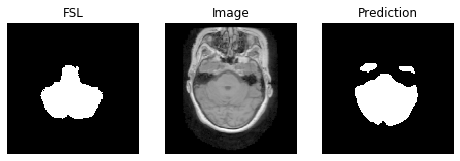

In [40]:
f50.vis_3d(yP,xP,pP, k=k, save_pth=save_pth)

___

### Save xP, yP, pP as Nifti files

In [28]:
# cur_df, cur_idx = f50.get_one_patient(df_2d, pt)
# cur_idx

In [29]:
pt

'/data-10tb/shared/skull/axial-2d//test/IXI/IXI002-Guys-0828-T1.anat/T1_biascorr_iso_'

In [30]:
f50.save_128_as_nifti(patient_pattern=pat, image=pP, suffix_name='p', test_name=IXI_TEST_3D, save_root_folder=SAVE_PTH_301_DATA )

*** Saved: /data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/IXI/IXI464-IOP-1029-T1.anat_T1_biascorr_iso_p.nii.gz


___

#### Nilearn

In [31]:
# from nilearn import plotting
# plotting.view_img(xP, bg_img=yP, threshold=None, opacity=0.5)

____

#### itkwidgets

In [32]:
# from itkwidgets import view, compare
# view(xP,label_image=pP, label_image_blend=0.7, slicing_planes=False, mode='x')
# # #compare(pP, yP, link_cmap=True)

___

## Violin plots

### IXI

In [10]:
save_name = f'3.01_IXI_TEST_3D_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name
df_3d = pd.read_csv(save_pth)
# print(df_3d.shape)
# df_3d.head(2)
df_model_2d = df_3d[['dice', 'jaccard']]
df_model_2d = df_model_2d.assign(model='2d', db='ixi')
df_model_2d.head(2)

,dice,jaccard,model,db
0,0.983481,0.967499,2d,ixi
1,0.981799,0.964248,2d,ixi


In [11]:
n3d = PATH_GIT_HUB / 'inne_lokalne/' / 'sathiesh_3d_results' / 'ixi_test_results.csv'
df_model_3d = pd.read_csv(n3d)
df_model_3d = df_model_3d[['dice_score', 'jaccard_score']]
df_model_3d.columns = ['dice', 'jaccard']
df_model_3d = df_model_3d.assign(model='3d', db='ixi')
print(df_model_3d.shape)
df_model_3d.head(2)

(556, 4)


,dice,jaccard,model,db
0,0.983632,0.967791,3d,ixi
1,0.983012,0.966591,3d,ixi


In [12]:
df_all = pd.concat([df_model_2d, df_model_3d],sort=False)
df_all.shape

(1112, 4)

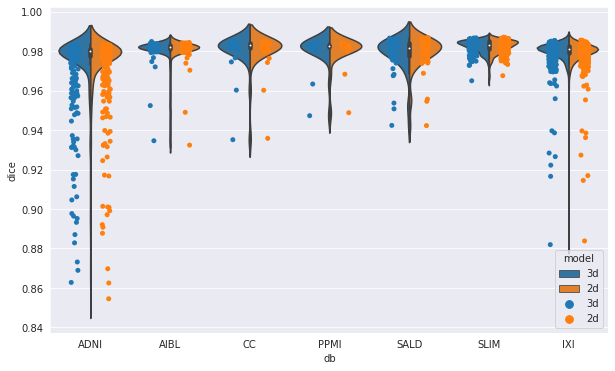

In [47]:
violin, ax = plt.subplots(figsize=(10,6))
ax = sns.violinplot(x='db', y='dice', hue='model', data=df_all, split=True)
ax = sns.stripplot(x="db", y="dice", hue='model', data=df_all, dodge=True)
#plt.savefig('/data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_dice_violin.png')

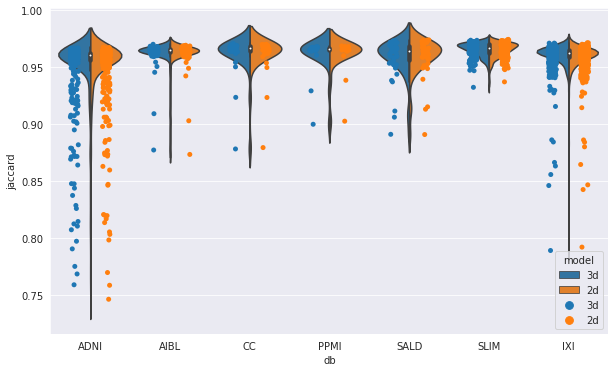

In [48]:
violin, ax = plt.subplots(figsize=(10,6))
ax = sns.violinplot(x='db', y='jaccard', hue='model', data=df_all, split=True)
ax = sns.stripplot(x="db", y="jaccard", hue='model', data=df_all, dodge=True)
#plt.savefig('/data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_jaccard_violin.png')

### TEST_3D

In [16]:
save_name = f'3.01_TEST_3D_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name

df_3d = pd.read_csv(save_pth)
print(df_3d.shape)
df_model_2d = df_3d[['dice', 'jaccard', 'db']]

df_model_2d.loc[df_model_2d['db'] == 'CalgaryCampinas', 'db'] = 'CC' 
df_model_2d.db = df_model_2d.db.str.strip()

df_model_2d = df_model_2d.assign(model='2d')
df_model_2d.head(2)

(927, 7)


,dice,jaccard,db,model
0,0.981809,0.964268,ADNI,2d
1,0.981435,0.963546,ADNI,2d


In [17]:
f50.get_db_names(df_3d)

['ADNI', 'AIBL', 'CalgaryCampinas', 'PPMI', 'SALD', 'SLIM']

In [18]:
n3d = PATH_GIT_HUB / 'inne_lokalne/' / 'sathiesh_3d_results' / 'test_results.csv'
df_model_3d = pd.read_csv(n3d)
df_model_3d = df_model_3d[['dice_score', 'jaccard_score', 'source']]
df_model_3d.columns = ['dice', 'jaccard', 'db']
df_model_3d = df_model_3d.assign(model='3d')
print(df_model_3d.shape)
df_model_3d.head(2)

(927, 4)


,dice,jaccard,db,model
0,0.981304,0.963293,ADNI,3d
1,0.981175,0.963046,ADNI,3d


In [19]:
df_all = pd.concat([df_model_2d, df_model_3d],sort=False)
print(df_all.shape)
df_all.head(2)

(1854, 4)


,dice,jaccard,db,model
0,0.981809,0.964268,ADNI,2d
1,0.981435,0.963546,ADNI,2d


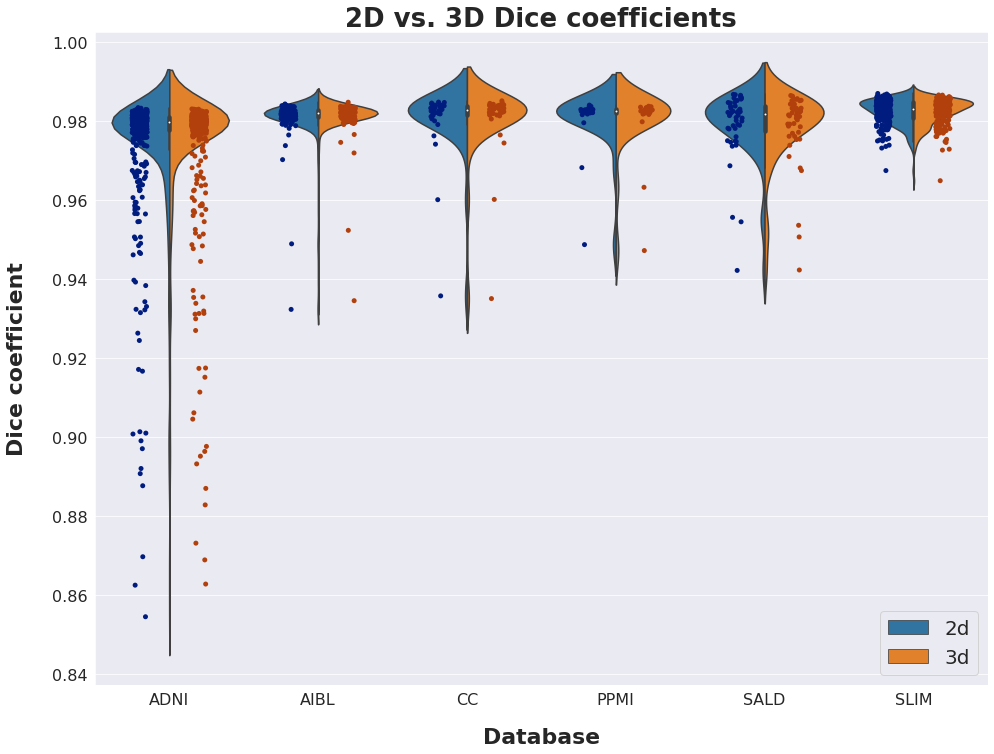

In [109]:
# https://seaborn.pydata.org/tutorial/color_palettes.html
#https://seaborn.pydata.org/generated/seaborn.violinplot.html

#current_palette = sns.color_palette()
#sns.palplot(current_palette)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

violin, ax = plt.subplots(figsize=(16,12))
ax = sns.violinplot(x='db', y='dice', hue='model', data=df_all, split=True)
ax = sns.stripplot(x="db", y="dice", hue='model', data=df_all, dodge=True, palette='dark')



ax.set_xlabel('Database', fontsize=22,weight='bold', labelpad=20)
ax.set_ylabel('Dice coefficient',fontsize=22, weight='bold', labelpad=25)
ax.set_title('2D vs. 3D Dice coefficients', fontsize=26, weight='bold')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=8)

#https://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend/46261486
handles, labels = ax.get_legend_handles_labels()

#https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.legend.html
ax.legend(handles[0:2], labels[0:2],loc=4, prop={'size': 20})


#ax.set(xlabel='Database', ylabel='Dice coefficient', title='2D vs. 3D Dice coeficcients')
plt.savefig('/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_TEST_3D_dice_violin_rgb.png')

# save to grayscale
rgb_name = '/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_TEST_3D_dice_violin_rgb.png'
gray_name = '/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_TEST_3D_dice_violin_gray.png'

Image.open(rgb_name).convert('L').save(gray_name)

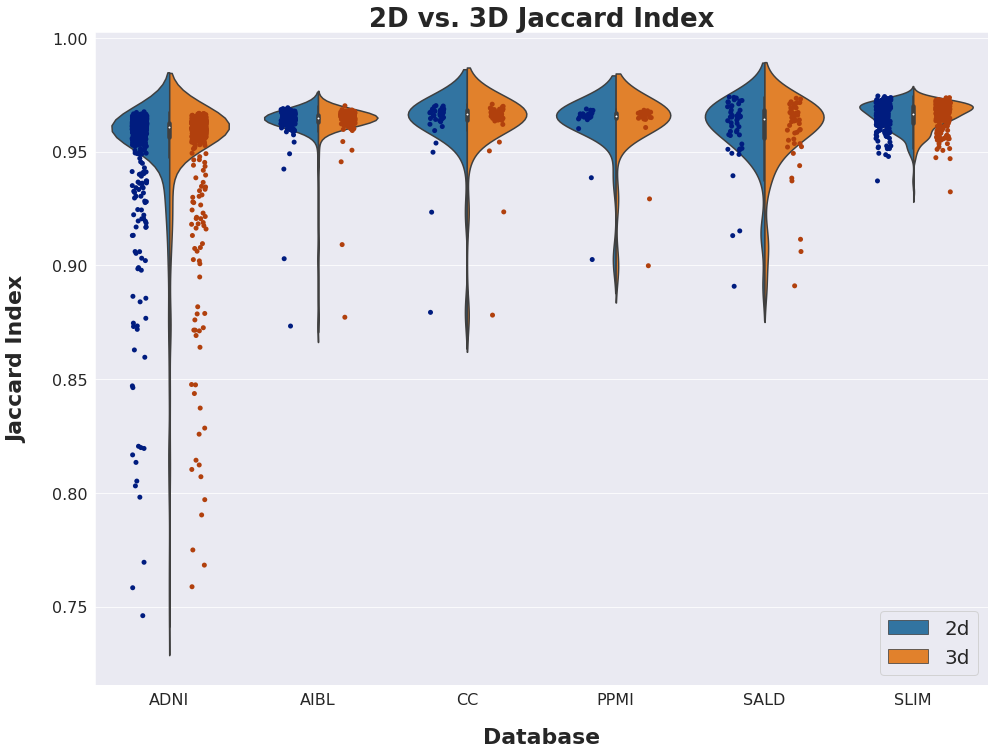

In [110]:
violin, ax = plt.subplots(figsize=(16,12))
ax = sns.violinplot(x='db', y='jaccard', hue='model', data=df_all, split=True)
ax = sns.stripplot(x="db", y="jaccard", hue='model', data=df_all, dodge=True, palette='dark')


ax.set_xlabel('Database', fontsize=22,weight='bold', labelpad=20)
ax.set_ylabel('Jaccard Index',fontsize=22, weight='bold', labelpad=25)
ax.set_title('2D vs. 3D Jaccard Index', fontsize=26, weight='bold')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=8)

#https://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend/46261486
handles, labels = ax.get_legend_handles_labels()

#https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.legend.html
ax.legend(handles[0:2], labels[0:2],loc=4, prop={'size': 20})


plt.savefig('/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_TEST_3D_jaccard_violin.png')

### IXI + TEST

#### TEST

In [15]:
save_name = f'3.01_TEST_3D_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name

df_3d_test = pd.read_csv(save_pth)
print(df_3d_test.shape)
df_model_2d_test = df_3d_test[['dice', 'jaccard', 'db']]

df_model_2d_test.loc[df_model_2d_test['db'] == 'CalgaryCampinas', 'db'] = 'CC' 
df_model_2d_test.db = df_model_2d_test.db.str.strip()

df_model_2d_test = df_model_2d_test.assign(model='2D')
df_model_2d_test.head(2)

(927, 7)


,dice,jaccard,db,model
0,0.981809,0.964268,ADNI,2D
1,0.981435,0.963546,ADNI,2D


In [16]:
n3d = PATH_GIT_HUB / 'inne_lokalne/' / 'sathiesh_3d_results' / 'test_results.csv'
df_model_3d_test = pd.read_csv(n3d)
df_model_3d_test = df_model_3d_test[['dice_score', 'jaccard_score', 'source']]
df_model_3d_test.columns = ['dice', 'jaccard', 'db']
df_model_3d_test = df_model_3d_test.assign(model='3D')
print(df_model_3d_test.shape)
df_model_3d_test.head(2)

(927, 4)


,dice,jaccard,db,model
0,0.981304,0.963293,ADNI,3D
1,0.981175,0.963046,ADNI,3D


#### IXI

In [17]:
save_name = f'3.01_IXI_TEST_3D_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name
df_3d_ixi = pd.read_csv(save_pth)
# print(df_3d.shape)
# df_3d.head(2)
df_model_2d_ixi = df_3d_ixi[['dice', 'jaccard']]
df_model_2d_ixi = df_model_2d_ixi.assign(model='2D', db='IXI')
print(df_model_2d_ixi.shape)
df_model_2d_ixi.head(2)

(556, 4)


,dice,jaccard,model,db
0,0.983481,0.967499,2D,IXI
1,0.981799,0.964248,2D,IXI


In [18]:
n3d = PATH_GIT_HUB / 'inne_lokalne/' / 'sathiesh_3d_results' / 'ixi_test_results.csv'
df_model_3d_ixi = pd.read_csv(n3d)
df_model_3d_ixi = df_model_3d_ixi[['dice_score', 'jaccard_score']]
df_model_3d_ixi.columns = ['dice', 'jaccard']
df_model_3d_ixi = df_model_3d_ixi.assign(model='3D', db='IXI')
print(df_model_3d_ixi.shape)
df_model_3d_ixi.head(2)

(556, 4)


,dice,jaccard,model,db
0,0.983632,0.967791,3D,IXI
1,0.983012,0.966591,3D,IXI


In [19]:
df_all = pd.concat([df_model_2d_test, df_model_2d_ixi, df_model_3d_test, df_model_3d_ixi], sort=False)
print(df_all.shape)

(2966, 4)


##### DICE for all

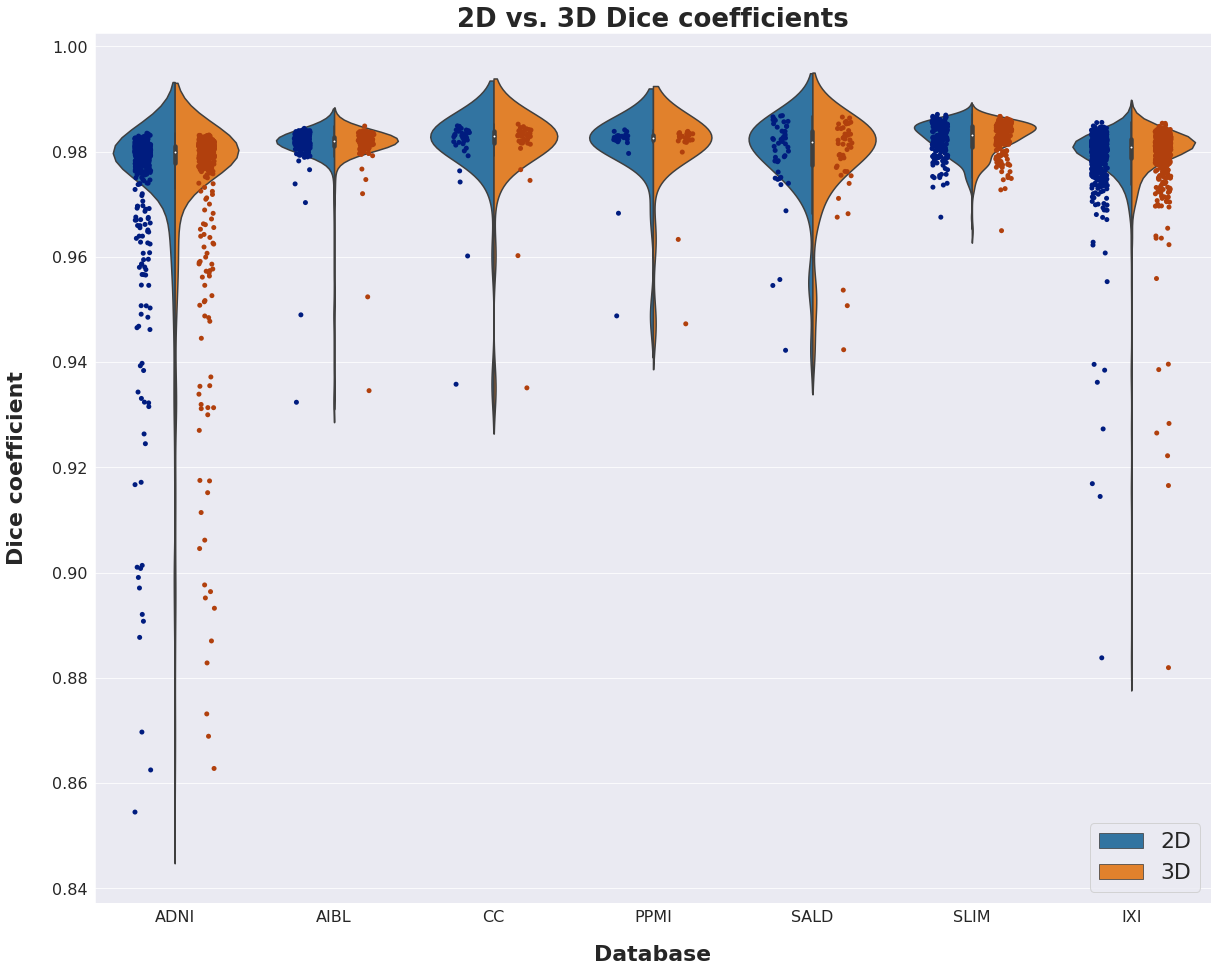

In [24]:
#https://python-graph-gallery.com/104-seaborn-themes/
sns.set_style("darkgrid")

# https://seaborn.pydata.org/tutorial/color_palettes.html
#https://seaborn.pydata.org/generated/seaborn.violinplot.html

#current_palette = sns.color_palette()
#sns.palplot(current_palette)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]


violin, ax = plt.subplots(figsize=(20,16))
ax = sns.violinplot(x='db', y='dice', hue='model', data=df_all, split=True)
ax = sns.stripplot(x="db", y="dice", hue='model', data=df_all, dodge=True, palette='dark')



ax.set_xlabel('Database', fontsize=22,weight='bold', labelpad=20)
ax.set_ylabel('Dice coefficient',fontsize=22, weight='bold', labelpad=25)
ax.set_title('2D vs. 3D Dice coefficients', fontsize=26, weight='bold')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=8)

#https://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend/46261486
handles, labels = ax.get_legend_handles_labels()

#https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.legend.html
ax.legend(handles[0:2], labels[0:2],loc=4, prop={'size': 22})
#ax.set(xlabel='Database', ylabel='Dice coefficient', title='2D vs. 3D Dice coeficcients')


rgb_name = '/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_ALL_dice_violin_rgb.png'
gray_name = '/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_ALL_dice_violin_gray.png'
plt.savefig(rgb_name, bbox_inches='tight', pad_inches=0.2)
# save to grayscale
Image.open(rgb_name).convert('L').save(gray_name)

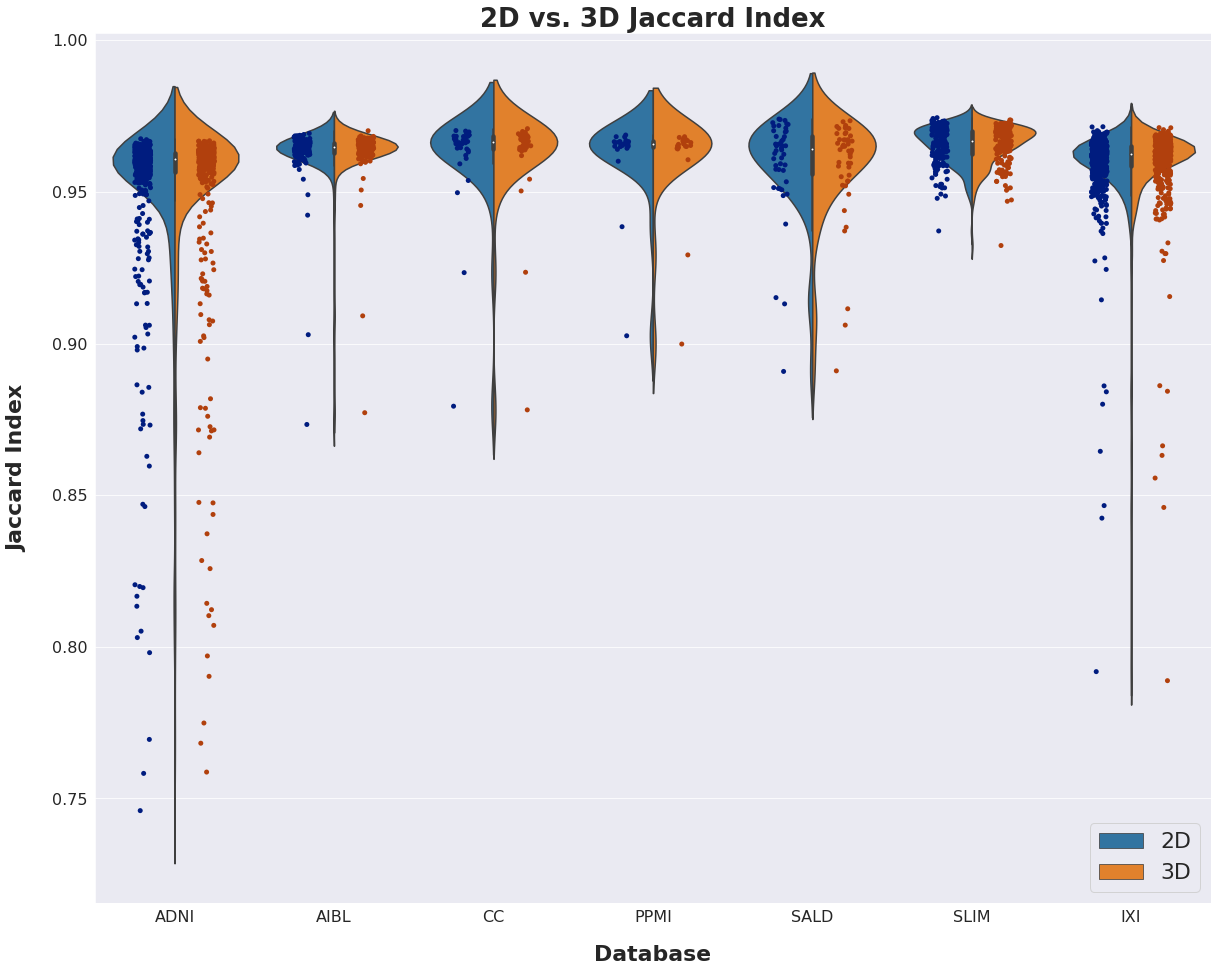

In [25]:
sns.set_style("darkgrid")

violin, ax = plt.subplots(figsize=(20,16))
ax = sns.violinplot(x='db', y='jaccard', hue='model', data=df_all, split=True)
ax = sns.stripplot(x="db", y="jaccard", hue='model', data=df_all, dodge=True, palette='dark')


ax.set_xlabel('Database', fontsize=22,weight='bold', labelpad=20)
ax.set_ylabel('Jaccard Index',fontsize=22, weight='bold', labelpad=25)
ax.set_title('2D vs. 3D Jaccard Index', fontsize=26, weight='bold')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=8)

#https://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend/46261486
handles, labels = ax.get_legend_handles_labels()

#https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.legend.html
ax.legend(handles[0:2], labels[0:2],loc=4, prop={'size': 22})


rgb_name = '/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_ALL_jaccard_violin_rgb.png'
gray_name = '/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_ALL_jaccard_violin_gray.png'
# RGB
plt.savefig(rgb_name, bbox_inches='tight', pad_inches=0.2)
# save to grayscale
Image.open(rgb_name).convert('L').save(gray_name)